---
title       : "Solving HJB equation for neoclassical growth models"
author      : Chiyoung Ahn (@chiyahn)
date        : 


`j using Dates; print(Dates.today())`
---

### About this document
Presented by Chiyoung Ahn (@chiyahn), written for `Weave.jl`, based on Ben Moll's [note](http://www.princeton.edu/~moll/HACTproject/HACT_Additional_Codes.pdf) and [code](http://www.princeton.edu/~moll/HACTproject/HJB_NGM_implicit.m).

In [1]:
using LinearAlgebra, Parameters, Plots, BenchmarkTools
gr(fmt = :png); # save plots in .png

## Model
Consider finding the optimal consumption plan $c(t)$ for

$$
\max_{\{c(t)\}_{t \geq 0} } \int e^{-\rho t } u(c(t)) dt
$$

with $u(c(t)) = c(t)^{1-\gamma} / (1-\gamma)$ for some $\gamma \neq 1$ and the following law of motion for $k$:

$$
\dot k(t) = F(k(t)) - \delta k(t) - c(t)
$$

## Numerical solution of HJBE
The corresponding HJB equation is

$$
\rho v (k) = \max_c u(c) + v'(k ) (F(k) - \delta k - c)
$$
The first order condition with respect to $c$ on the maximand function yields 

$$
u'(c) = v'(k)
$$

i.e., $c = (u')^{-1} (v' (k))$ for each $k$ at optimal.


### Upwind scheme and discretization of $\nabla v$
Note that $v$ is concave in $k$ and the drift of state variables can be either positive or negative. Basic idea of upwind scheme: use forward difference when the drift of the state variable $f(x, \alpha)$ is positive, backward difference when it is negative. Let $v'_{i, B}$ and $v'_{i, F}$ be $v'$ computed from backward difference and forward difference respectively.

Define the followings:

$$
s_{i,F} = F(k_i) - \delta k_i - (u')^{-1} (v'_{i,F}) \\
s_{i,B} = F(k_i) - \delta k_i - (u')^{-1} (v'_{i,B})
$$

Using the upwind scheme, the HJB eqaution can be rewritten as

$$
\rho v_i = u(c_i) + \dfrac{v_{i+1} - v_i}{\Delta k} s^+_{i,F} + \dfrac{v_i - v_{i-1}}{\Delta k} s^-_{i, B}
$$

for each $i$. This can be written in a compact matrix form

$$
\rho {\mathbf{v}} = {\mathbf{u}} + {\mathbf{A}}({\mathbf{v}}) {\mathbf{v}}
$$

such that the $i$th row of ${\mathbf{A}}({\mathbf{v}})$ is defined as 

$$
\begin{bmatrix}
0 & \cdots & 0 &  - \dfrac{s^-_{i,B}}{\Delta k} & \dfrac{s^-_{i,B}}{\Delta k} - \dfrac{s^-_{i,F}}{\Delta k} & \dfrac{s^-_{i,F}}{\Delta k} & 0 & \cdots & 0
\end{bmatrix}
$$

where the non-zero elements above are located in $i-1, i, i+1$th columns respectively. 

### Discretization of $u(c)$
One thing left to find is ${\mathbf{u}}$ at optimal consumption plan $c$. 

[Achdou et al. (2017)](http://www.princeton.edu/~moll/HACT.pdf) and [Fernandez-Villaverde et al. (2018)](https://www.sas.upenn.edu/~jesusfv/Financial_Frictions_Wealth_Distribution.pdf) suggest using the derivative of $v$ by the FOC above, which yields 

$$u (c) = u ( (u')^{-1} (v'(k))  ) $$

To compute the derivative, Achdou et al. (2017) and Fernandez-Villaverde et al. (2018) use the following discretization scheme:

$$
v'_i = v'_{i,F} {\mathbf{1}} ( s_{i, F} > 0) + v'_{i,B} {\mathbf{1}} ( s_{i, B} < 0) + \overline{v}'_i {\mathbf{1}} ( s_{i, F} < 0 < s_{i, B})
$$
where $\overline{v}'_i := u'(F(k_i) - \delta k_i)$, i.e., the steady state such that $s_i = 0$. This gives ${\mathbf{u}}$ by computing $u(c(v'_i))$ at each grid $i$.

Here's my take on this. I argue that there is no need to arbitrarily define $\overline{v}'_i$ to deal with the case when $s_{i}$ is taken to be zero.  Note that we need $\overline {v}_i'$ only for $u(c)$ when the current state is close enough to the steady state, i.e., $s_i \approx 0$ by taking $s_i = 0$. On the other hand, note that when $s_i = 0$, we can directly compute the consumption value by the law of motion $\dot k (t) = 0$ without relying on $v'$:

$$
c_i = F(k_i) - \delta k_i
$$
Hence, instead of defining $v'_i$ and $u(c(v'_i))$ accordingly, we can use the following consumption approximation scheme:

$$
c_i = c(v'_{i,F}) {\mathbf{1}} ( s_{i, F} > 0) + c(v'_{i,B}) {\mathbf{1}} ( s_{i, B} < 0) + [F(k_i) - \delta(k_i)] {\mathbf{1}} ( s_{i, F} < 0 < s_{i, B})
$$
so that $u(c(v'_i))$ can be now replaced with $u(c_i)$, which ameliorates the need of defining an arbitary discretization scheme for $v'_i$ when $s_i$ is close to zero.


## Setup
### Utility function

In [2]:
γ = 2.0
u(c) = c^(1-γ)/(1-γ) # payoff function by control variable (consumption)
u_prime(c) = c^(-γ) # derivative of payoff function by control variable (consumption)

u_prime (generic function with 1 method)

### Law of motion
Define a production as follows first:

In [3]:
A_productivity = 1.0
α = 0.3 
F(k) = A_productivity*k^α;

The corresponding law of motion for `k` given current `k` (state) and `c` (control)

In [4]:
δ = 0.05
f(k, c) = F(k) - δ*k - c; # law of motion for saving (state)

### Consumption function by inverse (`v_prime`)

In [5]:
c(v_prime) = v_prime^(-1/γ); # consumption by derivative of value function at certain k

### Parameters and grids

In [6]:
# ρ: utility discount rate
# δ: capital discount rate
# γ: CRRA parameter
# F: production function that maps k to a real number
# u: utility function that maps c to a real number
# u_prime: derivative of utility function that maps c to a real number
# f: law of motion function that maps k (state), c (control) to the derivative of k
# c: control by v_prime; maps v_prime (derivative of v at certain k) to consumption (control)
# c_ss: consumption (control) when v' = 0 (i.e. steady state)
params = (ρ = 0.05, δ = δ, γ = γ, F = F, u = u, u_prime = u_prime, f = f, c = c, c_ss = 0.0)

(ρ = 0.05, δ = 0.05, γ = 2.0, F = F, u = u, u_prime = u_prime, f = f, c = c, c_ss = 0.0)

In [7]:
# ks: grids for states (k) -- assume uniform grids
# Δv: step size for iteration on v
# vs0: initial guess for vs
# maxit: maximum number of iterations
# threshold: threshold to be used for termination condition (maximum(abs.(vs-vs_new)) < threshold)
# verbose: boolean that ables/disables a verbose option
k_ss = (α*A_productivity/(params.ρ+params.δ))^(1/(1-α))
ks = range(0.001*k_ss, stop = 2*k_ss, length = 10000)
settings = (ks = ks,
            Δv = 1000, 
            vs0 = (A_productivity .* ks .^ α) .^ (1-params.γ) / (1-params.γ) / params.ρ,
            maxit = 100, threshold = 1e-8, verbose = false)

(ks = 0.0048039866566730914:0.0009604129739663476:9.607973313346182, Δv = 1000, vs0 = [-99.2086, -93.9299, -89.6863, -86.1654, -83.1746, -80.5873, -78.3161, -76.2986, -74.4886, -72.851  …  -10.1475, -10.1472, -10.1469, -10.1466, -10.1463, -10.1459, -10.1456, -10.1453, -10.145, -10.1447], maxit = 100, threshold = 1.0e-8, verbose = false)

### Optimal plan solver

In [8]:
function compute_optimal_plans(params, settings)
    @unpack ρ, δ, γ, F, u, u_prime, f, c, c_ss = params
    @unpack ks, Δv, vs0, maxit, threshold, verbose = settings

    P = length(ks) # size of grids
    Δk = ks[2] - ks[1] # assume uniform grids

    # initial guess
    vs = vs0; 
    vs_history = zeros(P, maxit)
    # save control (consumption) plan as well
    cs = zeros(P) 

    # begin iterations
    for n in 1:maxit
        # compute derivatives by FD and BD
        dv = diff(vs) ./ Δk
        dv_f = [dv; dv[end]] # forward difference
        dv_b = [dv[1]; dv] # backward difference

        # define the corresponding drifts
        drift_f = f.(ks, c.(dv_f)) 
        drift_b = f.(ks, c.(dv_b))

        # steady states at boundary
        drift_f[end] = 0.0
        drift_b[1] = 0.0

        # compute consumptions and corresponding u(v)
        I_f = drift_f .> 0.0
        I_b = drift_b .< 0.0
        I_0 = 1 .- I_f-I_b

        dv_upwind = dv_f.*I_f + dv_b.*I_b
        cs_upwind = c.(dv_upwind)
        cs_0 = f.(ks, 0.0) # this gives consumption when the state is zero
        cs = cs_upwind.*I_f + cs_upwind.*I_b + cs_0.*I_0;
        
        us = u.(cs)

        # define the matrix A
        drift_f_upwind = max.(drift_f, 0.0) ./ Δk
        drift_b_upwind = min.(drift_b, 0.0) ./ Δk
        A = LinearAlgebra.Tridiagonal(-drift_b_upwind[2:P], 
                (-drift_f_upwind + drift_b_upwind), 
                drift_f_upwind[1:(P-1)]) 

        # solve the corresponding system to get vs_{n+1}
        vs_new = (Diagonal(fill((ρ + 1/Δv), P)) - A) \ (us + vs / Δv)

        # show distance between vs_{n+1} and vs_n if verbose option is one
        if (verbose) @show maximum(abs.(vs - vs_new)) end
        
        # check termination condition 
        if (maximum(abs.(vs-vs_new)) < threshold)
            if (verbose) println("Value function converged -- total number of iterations: $n") end
            return (vs = vs, cs = cs, vs_history = vs_history) 
        end
        
        # update vs_{n+1}
        vs = vs_new
        vs_history[:,n] = vs
    end
    return (vs = vs, cs = cs, vs_history = vs_history) 
end

compute_optimal_plans (generic function with 1 method)

## Solve

In [9]:
vs, cs, vs_history = @btime compute_optimal_plans(params, settings)

  91.563 ms (3581357 allocations: 87.49 MiB)


(vs = [-24.2392, -24.1564, -24.0827, -24.0161, -23.9549, -23.8982, -23.8452, -23.7955, -23.7485, -23.7038  …  -12.8475, -12.8472, -12.8469, -12.8466, -12.8464, -12.8461, -12.8458, -12.8456, -12.8453, -12.845], cs = [0.107707, 0.114193, 0.120002, 0.125288, 0.130158, 0.134687, 0.13893, 0.142929, 0.146717, 0.150321  …  1.87668, 1.87677, 1.87686, 1.87695, 1.87704, 1.87713, 1.87722, 1.87731, 1.8774, 1.87749], vs_history = [-31.8931 -25.1696 … 0.0 0.0; -31.5219 -25.0522 … 0.0 0.0; … ; -12.8986 -12.8628 … 0.0 0.0; -12.8984 -12.8625 … 0.0 0.0])

Plot for `v_n(k)` path by `n` (iteration step):

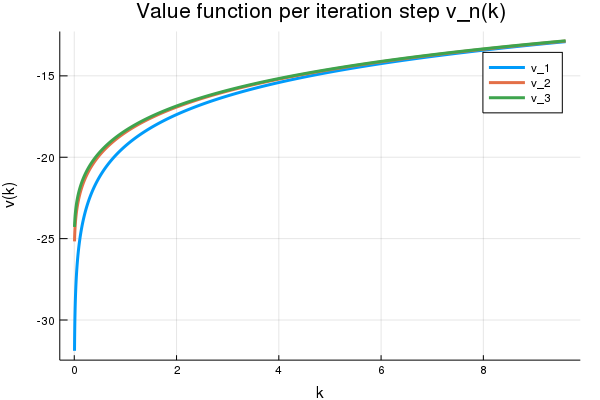

In [10]:
plot(ks, vs_history[:,1:3],
    linewidth = 3,
    title="Value function per iteration step v_n(k)",xaxis="k",yaxis="v(k)",
    label = string.("v_",1:3))

## Plots
### `v(k)`

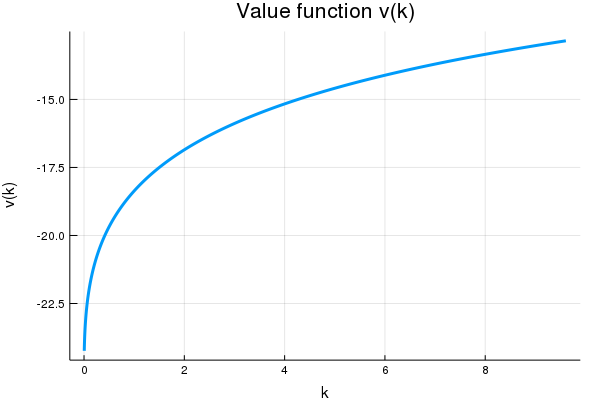

In [11]:
plot(ks, vs,
    linewidth = 3,
    title="Value function v(k)",xaxis="k",yaxis="v(k)",legend=false)

### `c(k)`

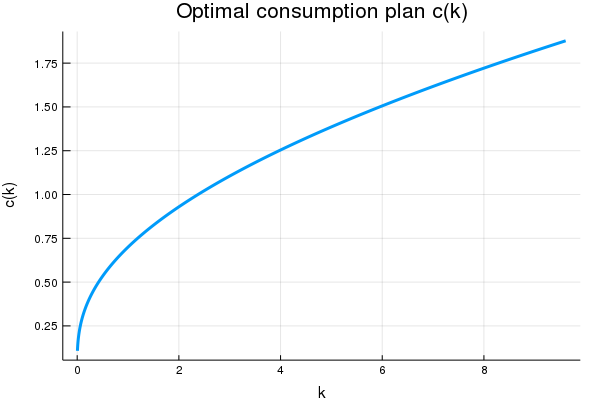

In [12]:
plot(ks, cs,
    lw = 3,
    title="Optimal consumption plan c(k)",xaxis="k",yaxis="c(k)",legend=false)

### `s(k)`

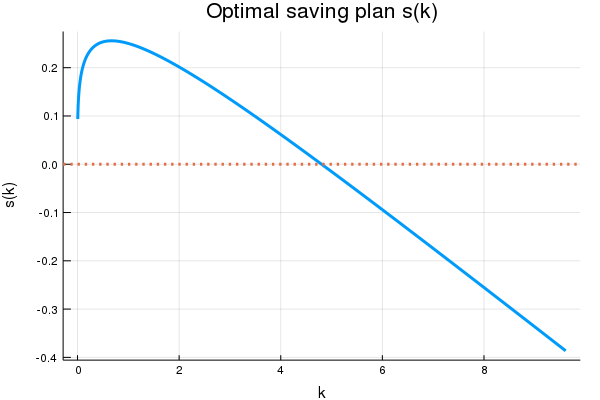

In [13]:
savings = f.(ks, cs) # Savings (states) according to optimal consumption plan
plot(ks, savings,
    linewidth = 3,
    title="Optimal saving plan s(k)",xaxis="k",yaxis="s(k)",legend=false)
plot!([.0], st = :hline, linestyle = :dot, lw = 3) # zero saving line